Задача тематическое моделирование

продолжаем исследование датасета с твитами

Скачиваем датасет (источник): положительные, отрицательные.

или можно через ноутбук

!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

как альтернатива можно скачать данные из Роспотребнадзора
https://zpp.rospotrebnadzor.ru/Forum/Appeals
для этого берём ноутбук parse_rospotrebnadzor.ipynb
устанавливаем количество скачанных страниц больше не 50-сят хотябы 500 и для анализа берём только вопросы так как ответы есть не всегда

что надо сделать
1. объединить в одну выборку (это только для твитов), для роспотребнадзора сформировать датасет из вопросов
2. провести исследование и выявить тематики о которых говорят в твитах (для твитов), а для роспотребнадзора так же выявить тематики о которых люди пишут проанализировать
3. сделать визуализацию кластеров тематик
4. проинтерпритировать получившиеся тематики

In [1]:
import pandas as pd
#from corus import load_lenta
import re
import numpy as np
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
#from multiprocessing import Pool
#from pymystem3 import Mystem

from string import punctuation
from stop_words import get_stop_words
from pymorphy3 import MorphAnalyzer
import re
import nltk


nltk.download('stopwords')
nltk.download('punkt')

import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', 1)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Загрузка датасета

In [2]:
import requests
from urllib.parse import urlencode

base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
public_key = 'https://disk.yandex.ru/i/koR5eMCToCZS2Q'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('positive.csv', 'wb') as f:
    f.write(download_response.content)

public_key = 'https://disk.yandex.ru/i/koR5eMCToCZS2Q'

# Получаем загрузочную ссылку
final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

# Загружаем файл и сохраняем его
download_response = requests.get(download_url)
with open('negative.csv', 'wb') as f:
    f.write(download_response.content)

In [3]:
response.json()

{'href': 'https://downloader.disk.yandex.ru/disk/cb8f6cde771c60efbabef8bdbc6cadd09821c1943c7938304310c1a2b9dcb4dd/65f0721f/lANyF5IzzZjLCLEpcnupSGdlbOIkqtyuJ-NIP7AIbEIXNJz--xiytwObDuJ60ALpgcqGwMJrs9fq_jT7dx2R6g%3D%3D?uid=0&filename=positive.csv&disposition=attachment&hash=i/gNo2h%2Bj3GKdpDCrU2t203VVX%2Bzkhhj2OSBBDTQkYBY0Vj8gGhv6Gc2pBFvt6Gnq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fvnd.ms-excel&owner_uid=89604752&fsize=26233379&hid=9ee316c501d0b7cc476755fcdf75e6f6&media_type=spreadsheet&tknv=v2',
 'method': 'GET',
 'templated': False}

In [20]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'], header= None) # заголовков в csv нет  -header= None калонка с нужным текстом 3 usecols=[3]
positive['label'] =  1
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'], header= None)
negative['label'] = 0
df = pd.concat([negative,positive], axis=0 )

df = df.sample(frac=1).reset_index(drop=True) #шафлим что бы данные не шли друг за другом для наглядности
df.head()

,text,label
0,"Купила все на свой вкус, кайнене ходила, как приложение ^^ исправляется)",1
1,@SJ_pineapple я еще не дорисовал:D ну если хочешь я тебе скину и вообще я не знаю мне чет не нрав:D,0
2,"В итоге, Обе-рек были первыми, Roman Rain — вторыми. Но да пофиг. Одно говно :)))",1
3,"@malysheva_lenka Это бывает) Выпадет, куда он денется!)))",0
4,Щас будем с Анютой украшать квартиру и наряжать ёлочку))),0


## Очистка теста

In [21]:
sw_1 = list(set(get_stop_words("ru")))
sw_2 = stopwords.words('russian')
sw = list(set(sw_1 + sw_2))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
  
    txt = str(txt)

    
    txt = re.sub(r'#\S+', '', txt) # удалит хештеги  
    txt = re.sub(r'@\S+', '', txt) # удалит упоминани 
    txt = re.sub(r'\d', '', txt) # удалит упоминани 
    txt = re.sub(r'http\S+\s*', '', txt) # удалит URL  
    txt = re.sub(r'RT|cc', '', txt) # удалит RT и cc
    txt = re.sub(r'ха\S+|ax\S+', ' смешно ', txt)
    txt = re.sub(r'\)\S+|:D\S+|D\S+', ' смешно ', txt)
    txt = re.sub(r'\(\S+', ' грустно ', txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub('\s+', ' ', txt) # заменит пробельные символы на 1 пробел 
    txt = "".join(c for c in txt if c.isalpha() or c == ' ') # удалит все что не буква 
    
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw and len(word) > 3]
    return " ".join(txt)

df['text'] = df['text'].apply(preprocess_text)
df.head(4)

,text,label
0,купить свой вкус кайнен ходить приложение исправляться,1
1,дорисовалd скинуть вообще знать нравd,0
2,итог оберека первый roman rain второй пофига один говно смешно,1
3,выпасть деться смешно,0


In [24]:
df.to_csv('data_prepare_csv') #

In [17]:
len(sw_1), len(sw_2), len(sw)

(421, 151, 422)

In [29]:
df.to_csv('data_prepare_with_lemm_csv') #

In [ ]:
df['token'] = df['tweet'].apply(lambda x: word_tokenize(x))
df.head()

In [33]:
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')

df['token'] = df['text'].apply(lambda x: word_tokenize(x))
df.head()
lemm = WordNetLemmatizer()
df['lemm'] = df['token'].apply(lambda x: [lemm.lemmatize(w,'n') for w in x])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [35]:
df.to_csv('data_prepare_with_lemm_csv') #

In [36]:
from gensim.models import *
from gensim import corpora

In [37]:
dictionary = corpora.Dictionary(df['lemm'])

dictionary.filter_extremes(no_below = 10, no_above = 0.9, keep_n=None) # игнорируем слова, которые встречаются реже 10 раз или составляют более 0.9 словаря 
dictionary.save('dict_text.dict')

In [38]:
corpus = [dictionary.doc2bow(text) for text in df['lemm']]
corpora.MmCorpus.serialize('lenta.model', corpus) 

In [39]:
%time 
lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=20, chunksize=50, update_every=1, passes=2)

CPU times: total: 0 ns
Wall time: 0 ns


In [40]:
%time 
lda.show_topics(num_topics=10, num_words=10, formatted=True)

CPU times: total: 0 ns
Wall time: 0 ns


[(19,
  '0.314*"ночь" + 0.174*"милый" + 0.112*"новогодний" + 0.095*"оставаться" + 0.086*"провести" + 0.049*"спросить" + 0.047*"спасть" + 0.033*"ездить" + 0.012*"мечтать" + 0.000*"спокойный"'),
 (2,
  '0.215*"мочь" + 0.193*"вообще" + 0.118*"какой" + 0.097*"фотка" + 0.092*"большой" + 0.069*"счастливый" + 0.051*"пятница" + 0.042*"петь" + 0.031*"весь" + 0.024*"мило"'),
 (3,
  '0.000*"торрент" + 0.000*"полистать" + 0.000*"follow" + 0.000*"разыгрывать" + 0.000*"исполнить" + 0.000*"чужое" + 0.000*"некуда" + 0.000*"хочуа" + 0.000*"кристиан" + 0.000*"езжать"'),
 (0,
  '0.399*"снег" + 0.346*"наш" + 0.080*"огромный" + 0.041*"труд" + 0.000*"улица" + 0.000*"круто" + 0.000*"идти" + 0.000*"весело" + 0.000*"поиграть" + 0.000*"снежок"'),
 (13,
  '0.339*"пойти" + 0.175*"работать" + 0.173*"найти" + 0.088*"деньга" + 0.075*"дорога" + 0.062*"концерт" + 0.023*"билет" + 0.000*"думать" + 0.000*"дом" + 0.000*"новый"'),
 (5,
  '0.991*"смешно" + 0.000*"утро" + 0.000*"завтра" + 0.000*"думать" + 0.000*"новый" + 0.0

In [41]:
lda_2 = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=100, chunksize=50, update_every=1, passes=2)
%time 
lda_2.show_topics(num_topics=10, num_words=10, formatted=True)

CPU times: total: 0 ns
Wall time: 0 ns


[(11,
  '0.000*"торрент" + 0.000*"полистать" + 0.000*"follow" + 0.000*"разыгрывать" + 0.000*"исполнить" + 0.000*"чужое" + 0.000*"некуда" + 0.000*"хочуа" + 0.000*"кристиан" + 0.000*"езжать"'),
 (15,
  '0.000*"торрент" + 0.000*"полистать" + 0.000*"follow" + 0.000*"разыгрывать" + 0.000*"исполнить" + 0.000*"чужое" + 0.000*"некуда" + 0.000*"хочуа" + 0.000*"кристиан" + 0.000*"езжать"'),
 (78,
  '0.000*"торрент" + 0.000*"полистать" + 0.000*"follow" + 0.000*"разыгрывать" + 0.000*"исполнить" + 0.000*"чужое" + 0.000*"некуда" + 0.000*"хочуа" + 0.000*"кристиан" + 0.000*"езжать"'),
 (51,
  '0.000*"торрент" + 0.000*"полистать" + 0.000*"follow" + 0.000*"разыгрывать" + 0.000*"исполнить" + 0.000*"чужое" + 0.000*"некуда" + 0.000*"хочуа" + 0.000*"кристиан" + 0.000*"езжать"'),
 (54,
  '0.333*"пятница" + 0.272*"петь" + 0.157*"мило" + 0.066*"загадывать" + 0.066*"ёлочка" + 0.061*"кабинет" + 0.000*"езжать" + 0.000*"некуда" + 0.000*"кристиан" + 0.000*"чужое"'),
 (87,
  '0.000*"торрент" + 0.000*"полистать" + 0.

In [45]:
from tqdm.notebook import tqdm

In [48]:
import matplotlib.pyplot as plt

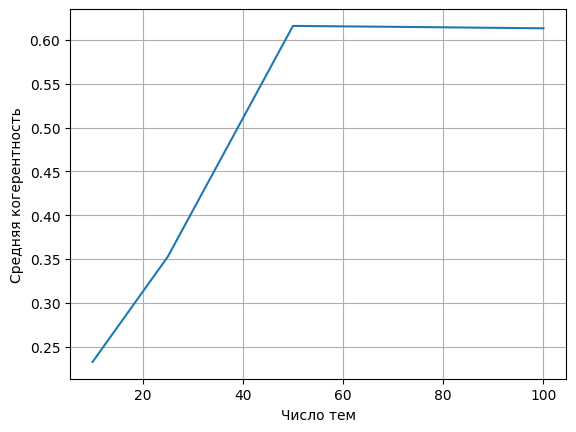

In [49]:
topics_list = [10, 25, 50, 75, 100]
coherences = []

for num in topics_list:
    lda = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=num, chunksize=50, update_every=1, passes=2)
    coherences.append(CoherenceModel(model=lda, texts=df['lemm'], dictionary=dictionary, coherence='c_v').get_coherence())

plt.plot(topics_list, coherences)
plt.grid()
plt.xlabel("Число тем")
plt.ylabel("Средняя когерентность")
plt.show()

# Вывод
#### В точке 50 тем наблюдается перегиб,     50 тем достаточно для оптимального разделени на тематики, при большем количестве тем когрентность перестает расти